# Query Google Maps Satellite Tiles from Given Coordinates and Zoom Level

Functions to retrieve Google Maps satellite tiles (256x256 RGB images) from specified longitudes, latitudes, and zoom levels.

Objectives:
- Retrieve the tile at a specified zoom level that covers a user-specified (longitude, latitude)
- Correctly georeference the tile (bounds of the tile, coordinates of the center of every pixel/mesh)

Preliminary work for a computer vision project...

Cyril Joly

In [1]:
from io import BytesIO
from itertools import product

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import requests
import rioxarray as xr
import xarray as xr
from geometry_utils import encode_dataset, get_coordinates, proj
from PIL import Image
from shapely.geometry import box
from tqdm.auto import tqdm


class GoogleMapsTiles:
    x = 6378137*np.pi
    XMIN = -x
    YMIN = -x
    XMAX = x
    YMAX = x
    CRS = 3857

    @classmethod
    def url_tile(cls, zoom, lon=None, lat=None, xtile=None, ytile=None):
        if isinstance(lon, float) and isinstance(lat, float):
            x, y = proj(lon, lat, 4326, cls.CRS)
            xtile_ = np.floor(2**zoom*(x-cls.XMIN)/(cls.XMAX-cls.XMIN)).astype(int)
            ytile_ = np.floor(2**zoom*(cls.YMAX-y)/(cls.YMAX-cls.YMIN)).astype(int)
        else:
            xtile_, ytile_ = xtile, ytile
        return xtile_, ytile_, f'https://mt1.google.com/vt/lyrs=s&x={xtile_}&y={ytile_}&z={zoom}'

    @staticmethod
    def url_to_numpy_array(url) -> np.ndarray:
        response = requests.get(url)
        image = Image.open(BytesIO(response.content))
        image_array = np.array(image)
        return image_array

    @classmethod
    def mesh_tile(cls, zoom, xtile, ytile):
        width = (cls.XMAX-cls.XMIN)/(2**zoom)
        height = (cls.YMAX-cls.YMIN)/(2**zoom)
        dx, dy = width/256, height/256
        xmin = cls.XMIN + xtile*width
        xmax = cls.XMIN + (xtile+1)*width
        ymax = cls.YMAX - ytile*height
        ymin = cls.YMAX - (ytile+1)*height
        x = xmin+dx/2 + dx*np.arange(256)
        y = ymin+dy/2 + dy*np.arange(256)
        return x, y

    @classmethod
    def download_raster(cls, zoom, place=None, lon=None, lat=None, xtile=None, ytile=None):
        if isinstance(place, str):
            lon_, lat_ = get_coordinates(place=place)
            xtile_, ytile_, url = cls.url_tile(zoom=zoom, lon=lon_, lat=lat_)
            tile = cls.url_to_numpy_array(url)
        elif isinstance(lon, float) and isinstance(lat, float):
            xtile_, ytile_, url = cls.url_tile(zoom=zoom, lon=lon, lat=lat)
            tile = cls.url_to_numpy_array(url)
        elif isinstance(xtile, np.integer) and isinstance(ytile, np.integer):
            xtile_, ytile_ = xtile, ytile
            tile = cls.url_to_numpy_array(cls.url_tile(zoom=zoom, xtile=xtile, ytile=ytile)[2])
        else:
            raise ValueError()
        x, y = cls.mesh_tile(zoom=zoom, xtile=xtile_, ytile=ytile_)

        ds = xr.Dataset({'red': (('y', 'x'), np.flip(tile[:, :, 0], axis=0)),
                         'green': (('y', 'x'), np.flip(tile[:, :, 1], axis=0)),
                         'blue': (('y', 'x'), np.flip(tile[:, :, 2], axis=0))},
                        coords={'y': ('y', y), 'x': ('x', x)})
        encode_dataset(ds, crs=cls.CRS)
        return ds

    @classmethod
    def plot_raster(cls, ds, figsize=None, gdf=None, show=True):
        x = ds.x.values
        y = ds.y.values
        dx, dy = np.diff(x)[0], np.diff(y)[0]
        xmin, xmax, ymin, ymax = x.min(), x.max(), y.min(), y.max()
        im = np.stack([ds['red'].values, ds['green'].values, ds['blue'].values], axis=-1)
        im = np.nan_to_num(im, nan=255).astype(int)
        plt.figure(figsize=figsize)
        plt.imshow(im, extent=(xmin-dx/2, xmax+dx/2, ymin-dy/2, ymax+dy/2), origin='lower')
        plt.xlim(xmin-dx/2, xmax+dx/2)
        plt.ylim(ymin-dy/2, ymax+dy/2)
        plt.gca().axis('off')
        if gdf is not None:
            gpd.clip(gdf.to_crs(cls.CRS), mask=(xmin-dx/2, ymin-dy/2, xmax+dx/2, ymax+dy/2)).plot(ax=plt.gca(), fc='none', lw=1)
        if show:
            plt.show()

    @classmethod
    def tiles_from_gdf(cls, zoom, gdf):
        union_gdf = gdf.to_crs(cls.CRS).unary_union
        lon_min, lat_min, lon_max, lat_max = gdf.to_crs(4326).total_bounds
        xtile_min, ytile_min, _ = cls.url_tile(zoom=zoom, lon=lon_min, lat=lat_max)
        xtile_max, ytile_max, _ = cls.url_tile(zoom=zoom, lon=lon_max, lat=lat_min)
        xx, yy = np.arange(xtile_min, xtile_max+1), np.arange(ytile_min, ytile_max+1)
        dataset = []
        for xtile, ytile in tqdm(product(xx, yy), total=len(xx)*len(yy)):
            ds = cls.download_raster(zoom, xtile=xtile, ytile=ytile)
            bounds_tile = box(ds.x.min(), ds.y.min(), ds.x.max(), ds.y.max())
            if bounds_tile.intersects(union_gdf):
                dataset.append(ds)
        dataset = xr.merge(dataset).fillna(255).astype(int)
        return dataset

In [2]:
ds = GoogleMapsTiles.download_raster(zoom=11, place='Paris')
ds

<xarray.Dataset> Size: 199kB
Dimensions:      (y: 256, x: 256)
Coordinates:
  * y            (y) float32 1kB 6.242e+06 6.242e+06 ... 6.262e+06 6.262e+06
  * x            (x) float32 1kB 2.544e+05 2.545e+05 ... 2.738e+05 2.739e+05
    spatial_ref  int32 4B 0
Data variables:
    red          (y, x) uint8 66kB 98 111 92 88 122 91 87 ... 92 86 98 76 91 79
    green        (y, x) uint8 66kB 100 113 94 90 124 93 ... 95 90 102 80 95 83
    blue         (y, x) uint8 66kB 76 89 72 68 103 72 72 ... 84 76 87 65 78 66

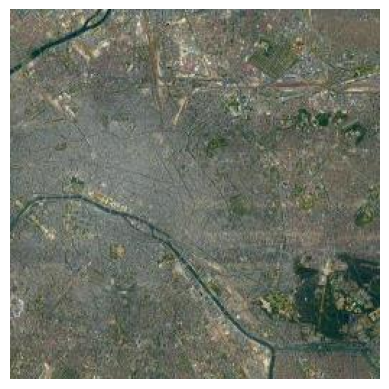

In [3]:
GoogleMapsTiles.plot_raster(ds)

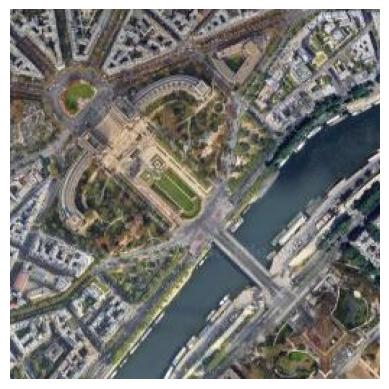

In [4]:
ds = GoogleMapsTiles.download_raster(zoom=15, place='Tour Eiffel, Paris')
GoogleMapsTiles.plot_raster(ds)

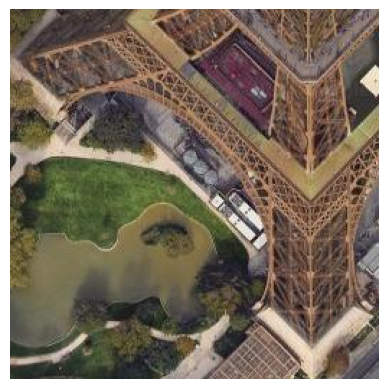

In [5]:
ds = GoogleMapsTiles.download_raster(zoom=18, place='Tour Eiffel, Paris')
GoogleMapsTiles.plot_raster(ds)

In [6]:
france = gpd.read_file("data/FRA_adm/FRA_adm0.shp")

In [ ]:
ds = GoogleMapsTiles.tiles_from_gdf(gdf=france, zoom=8)
ds

  0%|          | 0/121 [00:00<?, ?it/s]

In [ ]:
ds.rio.to_raster('export/test_tiles.tif', compress="LZW")

In [ ]:
GoogleMapsTiles.plot_raster(ds, gdf=france)